## Forecast of Airlines passengers data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
airlines = pd.read_excel('Airlines+Data.xlsx', parse_dates = True)
airlines.head()


,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [5]:
airlines.shape

(96, 2)

In [6]:
airlines.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [7]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


## Preprocessing of data

In [9]:
airlines["Date"] = pd.to_datetime(airlines.Month,format="%b-%y")
airlines["month"] =airlines.Date.dt.strftime("%b") # month extraction
airlines["year"] = airlines.Date.dt.strftime("%Y") # year extraction
airlines.head()

,Month,Passengers,Date,month,year
0,1995-01-01,112,1995-01-01,Jan,1995
1,1995-02-01,118,1995-02-01,Feb,1995
2,1995-03-01,132,1995-03-01,Mar,1995
3,1995-04-01,129,1995-04-01,Apr,1995
4,1995-05-01,121,1995-05-01,May,1995


<AxesSubplot:>

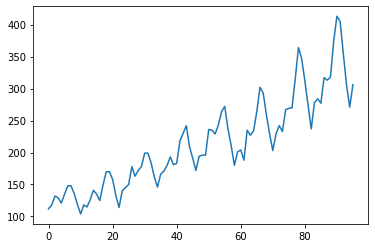

In [10]:
month =['01','02','03','04','05','06','07','08','09','10','11','12'] 
q = airlines['month'][0]
q[0:3]
airlines['monthly']= 0


for i in range(96):
    q = airlines['month'][i]
    airlines['monthly'][i] = q[0:3]
    
monthly_dummies = pd.DataFrame(pd.get_dummies(airlines['monthly']))
passengers = pd.concat([airlines.Passengers, monthly_dummies], axis = 1)

passengers['t'] = np.arange(1, 97) ## just a time variable
passengers['t_squared'] = passengers['t']*passengers['t']
passengers['log_psngr'] =  np.log(passengers['t'])
passengers.Passengers.plot()

## data is Upward exponential trend with multiplicative seasonality

In [12]:
passengers.head()

,Passengers,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_psngr
0,112,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0.000000
1,118,0,0,0,1,0,0,0,0,0,0,0,0,2,4,0.693147
2,132,0,0,0,0,0,0,0,1,0,0,0,0,3,9,1.098612
3,129,1,0,0,0,0,0,0,0,0,0,0,0,4,16,1.386294
4,121,0,0,0,0,0,0,0,0,1,0,0,0,5,25,1.609438


<AxesSubplot:xlabel='year', ylabel='Passengers'>

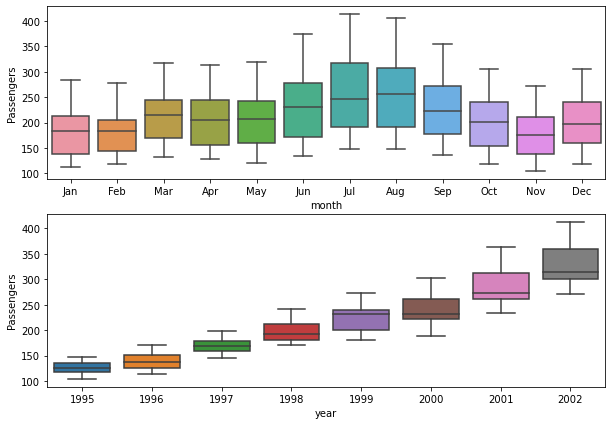

In [13]:
# Boxplot 
plt.figure(figsize=(10,7))

plt.subplot(211)
sns.boxplot(x = 'month',y="Passengers",data=airlines)   ## no outliers in the data
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=airlines)



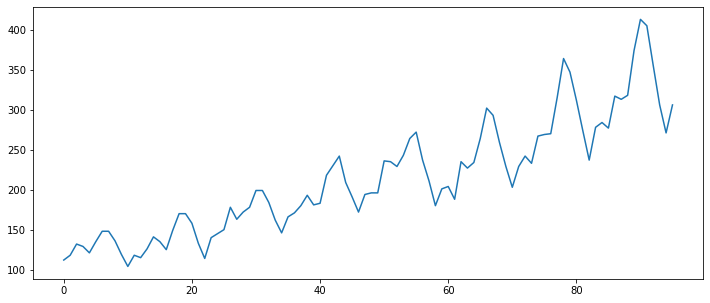

In [14]:
airlines['Passengers'].plot(figsize = (12,5))
plt.show()  ## data is Upward Linear Trend and additive seasonality

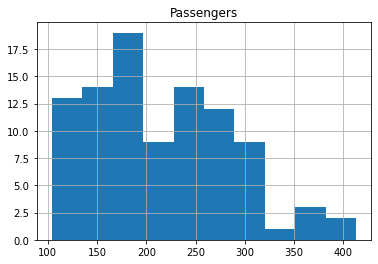

In [15]:
airlines.hist()
plt.show()  ## data is not normal 

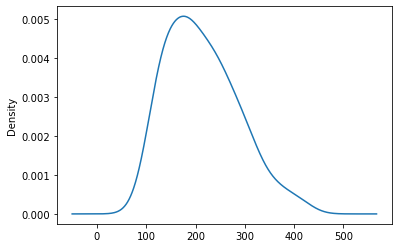

In [16]:
airlines['Passengers'].plot(kind='kde')
plt.show()  ## from this graph we can say that data is almost normally distributed

<AxesSubplot:xlabel='month', ylabel='year'>

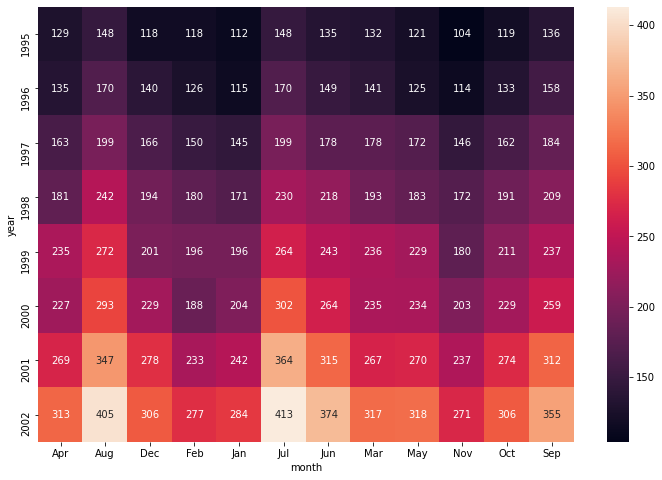

In [17]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=airlines,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot= True,fmt="g")  ## from this plot we can see that every year passengers are increasing

In [19]:
airlines.head()

,Month,Passengers,Date,month,year,monthly
0,1995-01-01,112,1995-01-01,Jan,1995,Jan
1,1995-02-01,118,1995-02-01,Feb,1995,Feb
2,1995-03-01,132,1995-03-01,Mar,1995,Mar
3,1995-04-01,129,1995-04-01,Apr,1995,Apr
4,1995-05-01,121,1995-05-01,May,1995,May


<AxesSubplot:xlabel='year', ylabel='Passengers'>

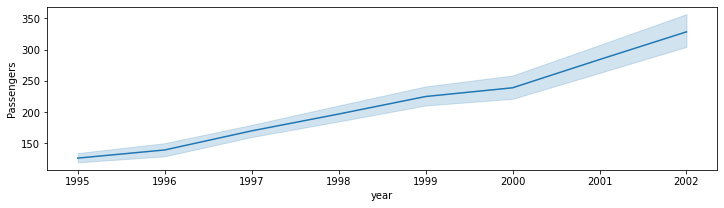

In [20]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=airlines)

In [22]:
## Splitting of data
train = passengers.head(84) 
test = passengers.tail(12)

In [ ]:
train.head()

In [ ]:
test.head()

## Model based Methods

In [23]:
## Linear model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t', data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

53.199236534802715

In [24]:
## Exponential model

Exp = smf.ols('log_psngr~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

170.71734430454802

In [25]:
#Quadratic model

Quad = smf.ols('Passengers~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

48.051888979330975

In [26]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

132.8197848142182

In [27]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

26.360817612086503

In [28]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_psngr~Jan*Feb*Mar*Apr*May*Jun*Jul*Aug*Sep*Oct*Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

299.0522579152964

In [29]:
#Multiplicative Additive Seasonality with Linear Trend

Mul_Add_sea = smf.ols('log_psngr~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test[['t','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

172.07938319941817

In [30]:
#Multiplicative Additive Seasonality with Quadratic Trend

Mul_Add_sea_quad = smf.ols('log_psngr~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea_quad = pd.Series(Mul_Add_sea_quad.predict(test[['t','t_squared','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_Mult_add_sea_quad = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Mult_add_sea_quad)))**2))
rmse_Mult_add_sea_quad 

277.1679632196361

In [31]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea","rmse_Mult_add_sea_quad"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea, rmse_Mult_add_sea_quad])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,26.360818
2,rmse_Quad,48.051889
0,rmse_linear,53.199237
3,rmse_add_sea,132.819785
1,rmse_Exp,170.717344
6,rmse_Mult_add_sea,172.079383
7,rmse_Mult_add_sea_quad,277.167963
5,rmse_Mult_sea,299.052258


In [32]:
final= smf.ols('log_psngr~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=passengers).fit()
pred= pd.Series(final.predict(passengers))
actual_pred = np.exp(pred)
actual_pred

errors = actual_pred - pred
pred

0     1.315147
1     1.467581
2     1.583021
3     1.682810
4     1.773689
        ...   
91    4.377718
92    4.371566
93    4.363303
94    4.353263
95    4.341697
Length: 96, dtype: float64

In [33]:
errors.mean()

45.42472719371434

## Data Driven Methods

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

## Moving Averages

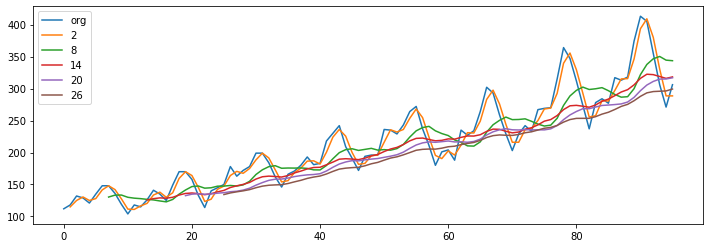

In [35]:
plt.figure(figsize=(12,4))
passengers.Passengers.plot(label="org")
for i in range(2,30,6):
    passengers["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

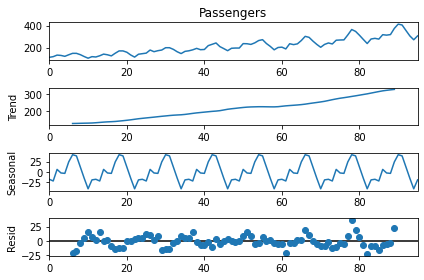

In [36]:
decompose = seasonal_decompose(passengers.Passengers,period=12)
decompose.plot()
plt.show()   

#### ACF and PACF Plots

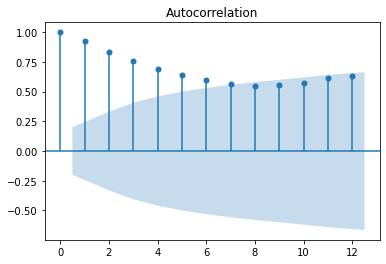

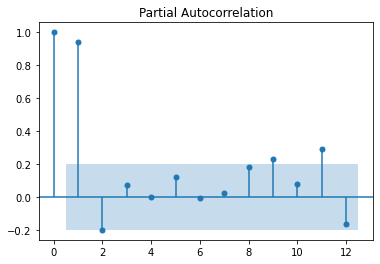

In [37]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(passengers.Passengers,lags=12)
tsa_plots.plot_pacf(passengers.Passengers,lags=12)
plt.show()


### Simple Exponential Method

In [38]:
## Evaluation metric MAPE

def MAPE(pred, act):
    temp = np.abs((pred - act)/act)*100
    return np.mean(temp)

In [39]:
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
mape_sme = MAPE(pred_ses,test.Passengers) 

In [40]:
## Holt's Method

hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
mape_hm = MAPE(pred_hw,test.Passengers) 

## Holts winter exponential smoothing with additive seasonality and additive trend


In [41]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
mape_haa = MAPE(pred_hwe_add_add,test.Passengers) 

## Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [42]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
mape_hma = MAPE(pred_hwe_mul_add,test.Passengers)

In [43]:
table = pd.DataFrame({'model': ['simple_exp_model','holts_model','hm_add_add','hm_mul_add'],'Mape_values':[mape_sme, mape_hm, mape_haa, mape_hma]})
table

,model,Mape_values
0,simple_exp_model,13.411275
1,holts_model,23.530720
2,hm_add_add,5.495939
3,hm_mul_add,2.821238


In [48]:
## Final Model by combining train and test
hwe_model_mul_add = ExponentialSmoothing(passengers["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()

## Forecast for next 10 time periods
hwe_model_mul_add.forecast(10)

96     312.899164
97     308.170903
98     355.533272
99     345.770384
100    345.697110
101    392.472018
102    436.501550
103    429.860620
104    380.172862
105    332.318642
dtype: float64

In [49]:
passengers.Passengers

0     112
1     118
2     132
3     129
4     121
     ... 
91    405
92    355
93    306
94    271
95    306
Name: Passengers, Length: 96, dtype: int64